## Notes on features to choose:

### From Kaggle:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis
* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook



### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

### Pipeline To Do:
* Look into kriging regression model for geospatial features
* Plot price to gender/age/subregion.
* subregions
    * linear reg to predict price just with subregion and size
    * mean/sd/var/median. 
    * see how well you can predict the sub-region by using price and size of home as features. 
    * max floors vs. price per subregion

### Import Libraries & Data

In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks", palette="muted", color_codes=True)

In [45]:
# load dataset


df = pd.read_csv("./merged_w_build_year_2017-05-30.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)

df.shape

(37659, 458)

In [46]:
# Considering the predictors having high or some correlation with price_doc (from EDA)

vars_subset = ['full_sqrt', 'life_sq^2', 'floor', 'area_km', 'density','year', 'month',
               'max_floor', 'material', 'num_room', 'area_m', 'age','work_share',
               'kitch_sq', 'state', 'product_type', 'sub_area', 'indust_part', 'sport_objects_raion',
               'oil_chemistry_raion', 'metro_min_avto', 'green_zone_km', 'industrial_km', 'kremlin_km',
               'radiation_km', 'ts_km', 'fitness_km', 'stadium_km', 'trc_sqm_5000', 'park_km']

df = df[vars_subset]

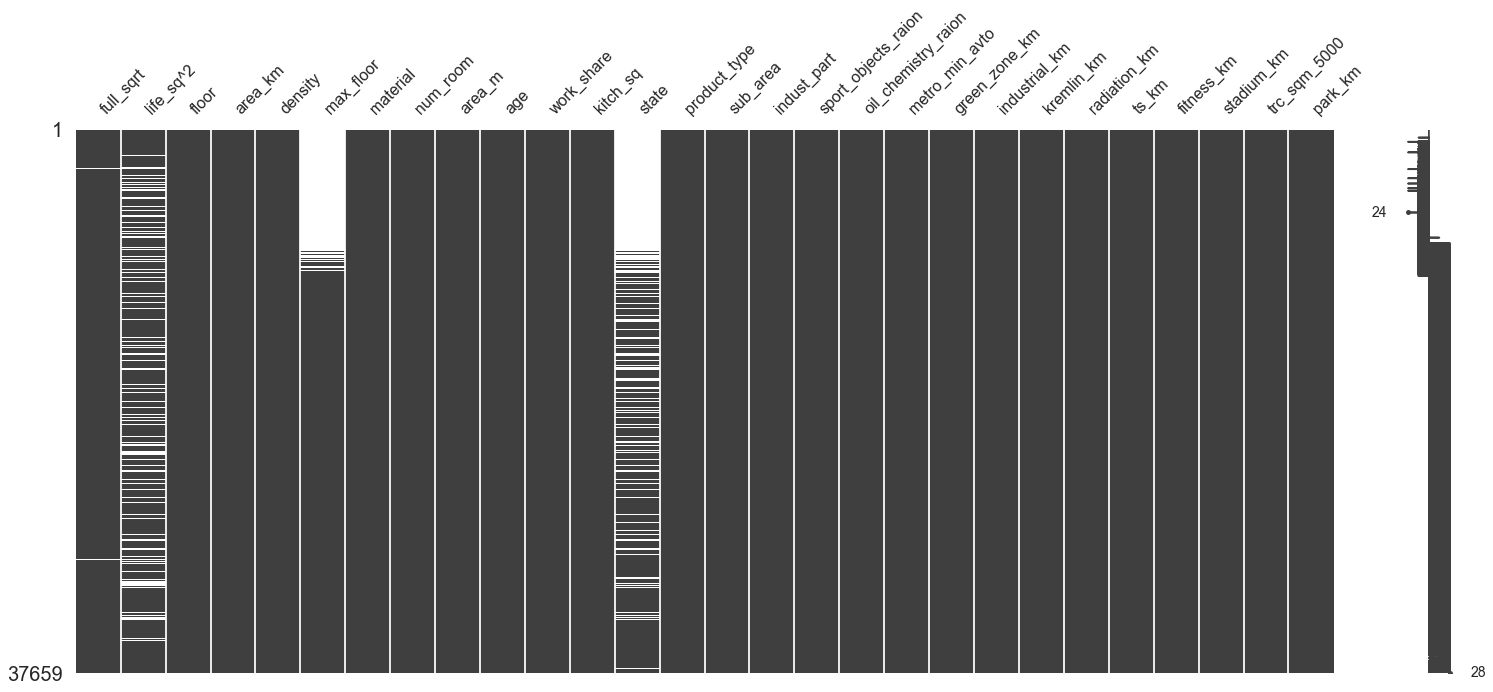

In [47]:
import missingno as msno

# df.set_index('timestamp')
filtered_data = msno.nullity_filter(df, filter='bottom', n=50, p=0.99) # or filter='top'

# msno.missingno.matrix(filtered_data)
msno.missingno.matrix(df_subset)

## State

In [48]:
np.sum(df['state'].isnull())

13934

State  has about 1/3 of it's data missing. With it's strong feature importance in a variety of different models, we decided to try and find a way to regress against build_year to predict the missing values. 

**Split the data into a train/test set, with the test set being the observations where build_year are null.**

In [49]:
# from sklearn import preprocessing

# for feature in df.columns:
#     if df[feature].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(df[feature].values)) 
#         df[feature] = lbl.transform(list(df[feature].values))

In [51]:
y_train = df.loc[df['state'].notnull(), 'state']
X_train = df.loc[df['state'].notnull(), df.columns != 'state']
X_test = df.loc[df['state'].isnull(), df.columns != 'state']

print y_train.shape, X_train.shape, X_test.shape

# X_train = X_train.select_dtypes(include=['float'], )
# X_test = X_test.select_dtypes(exclude=['float'])
# y_train = y_train.select_dtypes(exclude=['float'])

(23725,) (23725, 29) (13934, 29)


In [1]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=500, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

/Users/rezarad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'X_train' is not defined

In [53]:
num_boost_round = 131

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

In [54]:
y_test = model.predict(dtest)

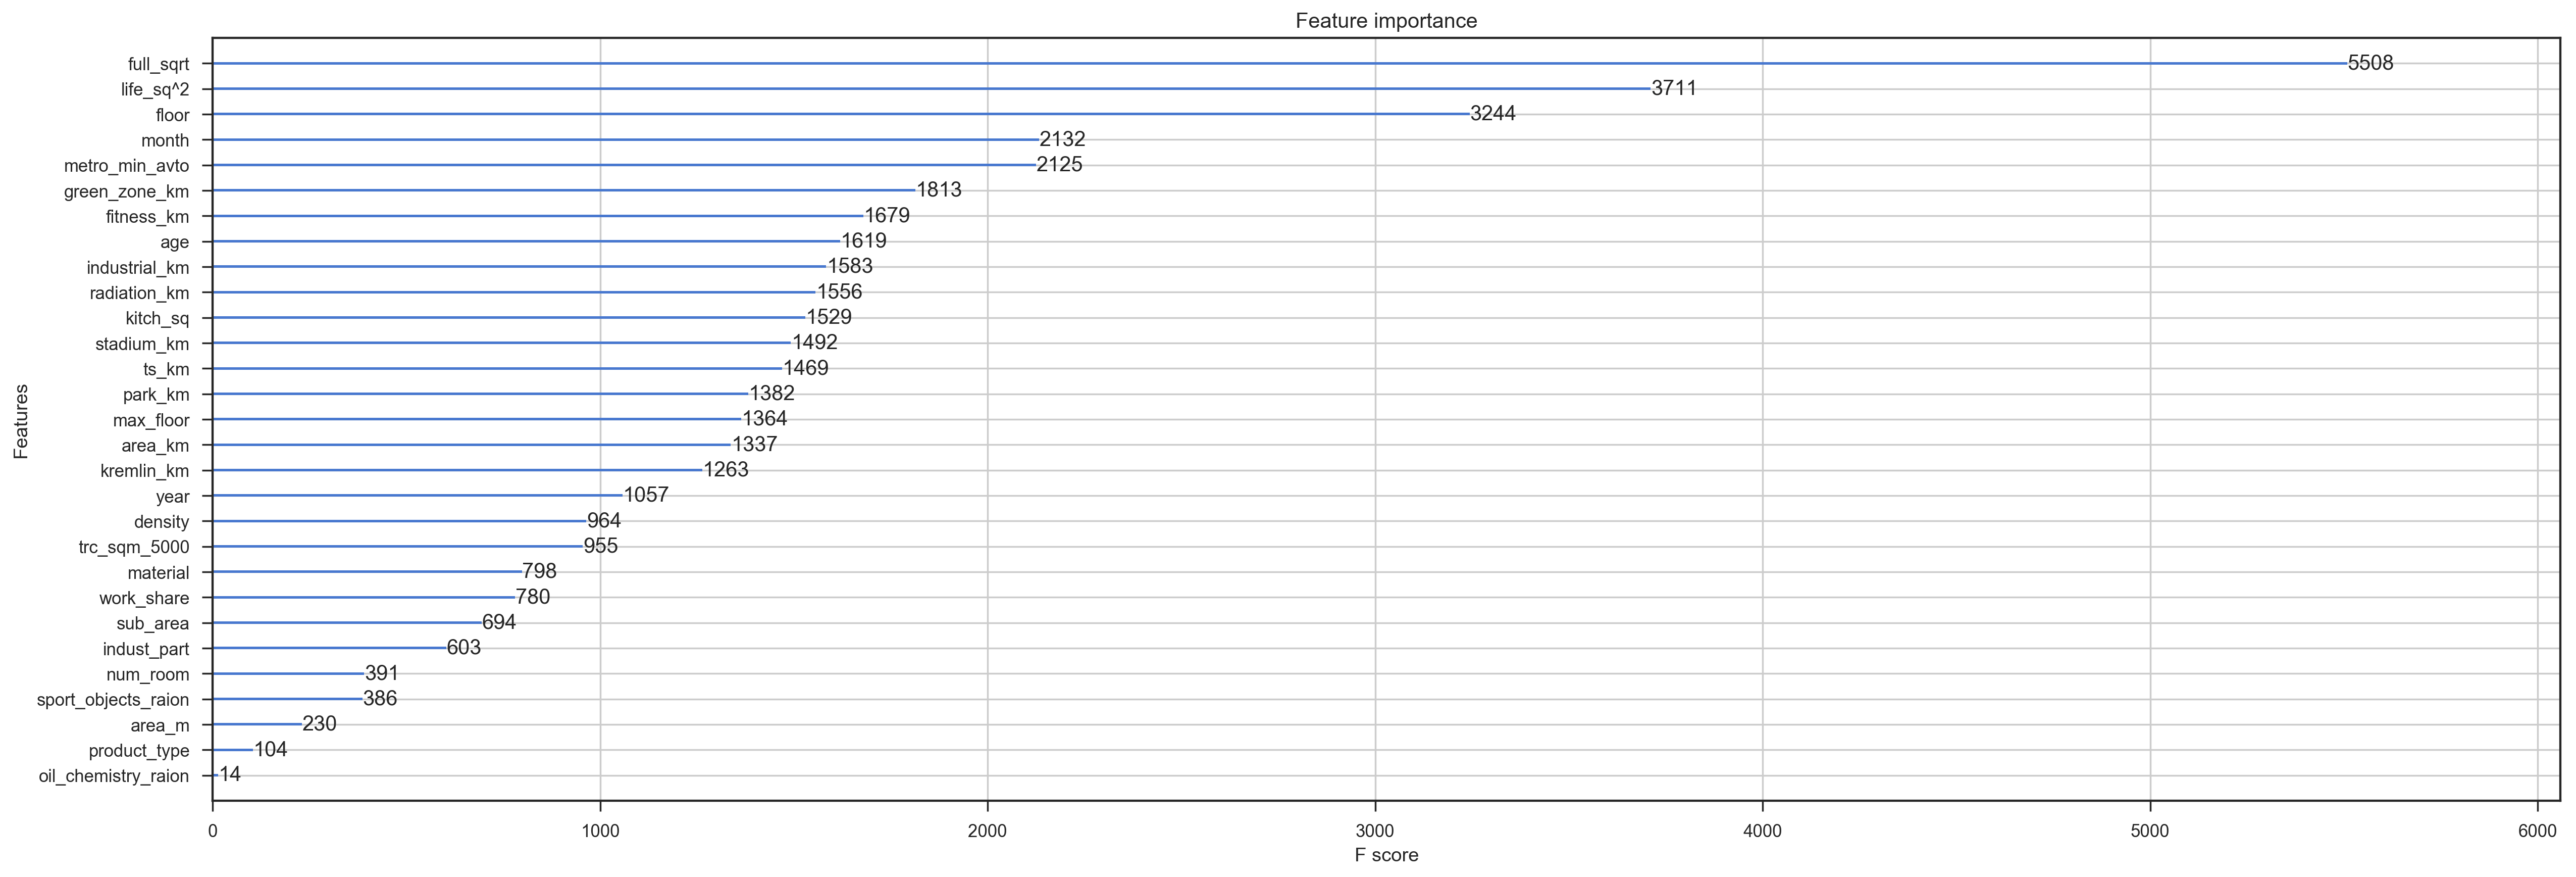

In [55]:
# plot the important features #
fig, ax = plt.subplots(figsize=(24,8), dpi=250)
xgb.plot_importance(model, height=.1, ax=ax)
plt.show()

In [56]:
print y_test.shape, X_test.shape

(13934,) (13934, 29)


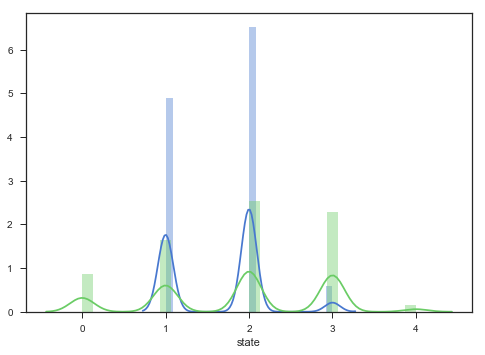

In [67]:
import seaborn as sns

sns.distplot(y_test)
sns.distplot(y_train)

### Impute predicted state values

In [57]:
df.loc[df['state'].isnull(), df.columns == 'state'] = y_test

In [58]:
np.sum(df['state'].isnull())

0

No N/A values remaining for state!

### Export to new data files

In [60]:
df_old = pd.read_csv('./merged_w_build_year_2017-05-30.csv')

In [68]:
df_old['state'] = df['state']  

In [71]:
np.sum(df_old['state'].isnull())

0

In [72]:
df_old.to_csv('./merged_w_state_build_{0}.csv'.format(datetime.date(datetime.now())), index=False)